# Survey Data Analysis: Bot Response Detection

This notebook analyzes survey responses to identify and filter out bot responses using multiple detection methods.

In [76]:
# =============================================================================
# IMPORTS AND SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# GLOBAL PLOTTING SETTINGS FOR PAPER-QUALITY FIGURES
# =============================================================================

# Set figure size (consistent across all figures, designed for 0.33 linewidth in paper)
FIGSIZE_SINGLE = (7, 6)
FIGSIZE_DOUBLE = (12, 5)
FIGSIZE_LARGE = (10, 8)
FIGSIZE_SMALL_SQUARE = (7, 6)
FIGSIZE_SMALL_SQUARE2 = (6, 5)


# ----------------------------
# Font sizes small figures (increased for readability at small sizes)
FONT_SIZE_TITLE_large = 22
FONT_SIZE_LABEL_large = 22
FONT_SIZE_TICK_large = 20
FONT_SIZE_LEGEND_large = 20
FONT_SIZE_ANNOTATION_large = 18

# Line widths
LINEWIDTH_AXIS_large = 1.8
LINEWIDTH_PLOT_large = 2.8
LINEWIDTH_GRID_large = 1
# ----------------------------

# ----------------------------
# Font sizes normal figures (increased for readability at small sizes)
FONT_SIZE_TITLE = 22
FONT_SIZE_LABEL = 22
FONT_SIZE_TICK = 20
FONT_SIZE_LEGEND = 20
FONT_SIZE_ANNOTATION = 18

# Line widths
LINEWIDTH_AXIS = 1.8
LINEWIDTH_PLOT = 2.8
LINEWIDTH_GRID = 1
# ----------------------------




# Neutral color palette (muted, grayscale-friendly)
COLOR_dark = '#4a4a4a'      # Dark gray
COLOR_dark = '#757575'    # Medium gray
COLOR_dark3 = '#9e9e9e'     # Light gray
COLOR_HIGHLIGHT = '#d32f2f'    # Muted red for emphasis
COLOR_POSITIVE = '#388e3c'     # Muted green
COLOR_NEUTRAL = '#1976d2'      # Muted blue


# make muted colors pastel
color_palette = sns.color_palette("pastel")
COLOR_PRIMARY = color_palette[0]
COLOR_SECONDARY = color_palette[1]
COLOR_TERTIARY = color_palette[2]


# Color palettes for multi-category plots
COLORS_CATEGORICAL = ['#4a4a4a', '#757575', '#9e9e9e', '#616161', '#424242']
COLORS_SEQUENTIAL = ['#e0e0e0', '#bdbdbd', '#9e9e9e', '#757575', '#616161', '#424242']

# Configure matplotlib defaults
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'figure.figsize': FIGSIZE_SINGLE,
    'font.size': FONT_SIZE_TICK,
    'axes.labelsize': FONT_SIZE_LABEL,
    'axes.titlesize': FONT_SIZE_TITLE,
    'xtick.labelsize': FONT_SIZE_TICK,
    'ytick.labelsize': FONT_SIZE_TICK,
    'legend.fontsize': FONT_SIZE_LEGEND,
    'axes.linewidth': LINEWIDTH_AXIS,
    'grid.linewidth': LINEWIDTH_GRID,
    'lines.linewidth': LINEWIDTH_PLOT,
    'patch.linewidth': LINEWIDTH_AXIS,
    'xtick.major.width': LINEWIDTH_AXIS,
    'ytick.major.width': LINEWIDTH_AXIS,
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#d0d0d0',
    'grid.alpha': 0.5,
})

# Seaborn style
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)

## Data Loading and Preprocessing

In [77]:
# df_processed.to_csv('../../data/processed_survey_data_full.csv', index=False)

# load processed data
df_processed = pd.read_csv('../../data/processed_survey_data_full.csv')
# df_processed['Q_DeviceType'] = df_processed['Q2_Operating System (Click to write the question text - Operating System)'].map(mapping_os)

df_processed.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,LocationLatitude,...,Q33_Click Count (Timing - Click Count),source,Q31 - Topics (Q31 - Topics),Q_AmbiguousTextPresent,Q_AmbiguousTextQuestions,Q_StraightliningCount,Q_StraightliningPercentage,Q_UnansweredPercentage,Q_UnansweredQuestions,Q_DeviceType
0,2025-05-30 17:38:51,2025-05-30 17:39:26,IP Address,172.56.198.246,100,34,True,2025-05-30 17:39:26,R_10Vt2XOXN6SuMKt,42.4280,...,2.0,NaN,Unknown,False,NaN,0,0,0.636364,"QID8,QID18,QID23,QID20,QID12,QID19,QID24,QID14...",Desktop
1,2025-05-30 17:40:05,2025-05-30 17:40:27,IP Address,172.56.198.246,100,22,True,2025-05-30 17:40:27,R_1PdRtcYCP18cwao,42.4280,...,1.0,NaN,NaN,False,NaN,0,0,0.909091,"QID8,QID41,QID18,QID23,QID20,QID12,QID3,QID19,...",Desktop
2,2025-05-30 17:43:23,2025-05-30 17:45:18,IP Address,172.56.198.246,100,114,True,2025-05-30 17:45:19,R_4VjzMnskvmj6EJb,42.4280,...,2.0,NaN,NaN,False,NaN,0,0,0.954545,"QID9,QID8,QID41,QID18,QID23,QID20,QID12,QID3,Q...",Desktop
3,2025-05-30 17:54:17,2025-05-30 18:01:30,IP Address,96.31.87.172,100,433,True,2025-05-30 18:01:31,R_OqJzrxj5ZAuEHND,28.0109,...,12.0,NaN,Unknown,False,NaN,0,0,0.000000,NaN,Mobile
4,2025-05-30 17:57:51,2025-05-30 18:01:42,IP Address,102.129.235.101,100,230,True,2025-05-30 18:01:42,R_2s1QIKcA8za4mPz,38.9149,...,12.0,NaN,NaN,False,NaN,0,0,0.045455,QID22,Mobile


-----------------

In [92]:
# a. 
RESULTS_TRACKER = [] #  a tracker of results for each analysis step.
df = df_processed.copy()

# 1. automated traffic risk signals

In [93]:

# filter out recaptcha score < threshold
def filter_recaptcha_score(df, recaptcha_threshold):
    if "Q_RecaptchaScore" in df.columns:
        filtered_df = df[df["Q_RecaptchaScore"] >= recaptcha_threshold].copy()
        return filtered_df
    else:
        return df
    
recaptcha_threshold = 0.6
df_after_recaptcha = filter_recaptcha_score(df, recaptcha_threshold = recaptcha_threshold)
RESULTS_TRACKER.append({
    "step": "Recaptcha Score",
    "threshold": recaptcha_threshold,
    "removed": len(df) - len(df_after_recaptcha),
    "remaining": len(df_after_recaptcha),
    "percentage_removed": (len(df) - len(df_after_recaptcha)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_recaptcha)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_recaptcha) / len(df_processed) * 100,
    "description": "Removed entries with Recaptcha Score below 0.5."
})




display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_recaptcha.copy()


,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.


In [94]:
# filter out fraud score > threshold
def filter_fraud_score(df, fraud_threshold):
    if "Q_RelevantIDFraudScore" in df.columns:
        filtered_df = df[df["Q_RelevantIDFraudScore"] <= fraud_threshold].copy()
        return filtered_df
    else:
        return df
    
fraud_threshold = 30

df_after_fraud = filter_fraud_score(df, fraud_threshold=fraud_threshold)
RESULTS_TRACKER.append({
    "step": "Fraud Score",
    "threshold": "30",
    "removed": len(df) - len(df_after_fraud),
    "remaining": len(df_after_fraud),
    "percentage_removed": (len(df) - len(df_after_fraud)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_fraud)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_fraud) / len(df_processed) * 100,
    "description": "Removed entries with Fraud Score above 50."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_fraud.copy()


,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.


In [95]:
# function to filter out respondents with ambiguous text present
def filter_ambiguous_text(df, ambiguous_text_threshold):
    if not ambiguous_text_threshold:
        return df
    filtered_df = df[df["Q_AmbiguousTextPresent"] == False].copy()
    return filtered_df

ambiguous_text_threshold = True

df_after_ambiguous_text = filter_ambiguous_text(df, ambiguous_text_threshold)
RESULTS_TRACKER.append({
    "step": "Ambiguous Text Present",
    "threshold": "True",
    "removed": len(df) - len(df_after_ambiguous_text),
    "remaining": len(df_after_ambiguous_text),
    "percentage_removed": (len(df) - len(df_after_ambiguous_text)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_ambiguous_text)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_ambiguous_text) / len(df_processed) * 100,
    "description": "Removed entries with ambiguous text present."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_ambiguous_text.copy()

,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.


# 2. Duplicates

In [96]:

def filter_duplicates(df_, ip_duplicate_threshold=1):
    """
    Remove rows belonging to any (IPAddress, Browser, Version, OS, Resolution) group
    whose size is > ip_duplicate_threshold. Mirrors the original behavior but vectorized.
    """
    df = df_.copy()
    
    if "Q_DuplicateRespondent" in df.columns:
        # remove True entries
        df = df[df["Q_DuplicateRespondent"] != True]
    if "Q_RelevantIDDuplicate" in df.columns:
        # remove True entries
        df = df[df["Q_RelevantIDDuplicate"] != True]

    cols = [
        "IPAddress",
        "Q2_Browser (Click to write the question text - Browser)",
        "Q2_Version (Click to write the question text - Version)",
        "Q2_Operating System (Click to write the question text - Operating System)",
        "Q2_Resolution (Click to write the question text - Resolution)",
    ]

    if "IPAddress" not in df.columns:
        return df

    # ---- Diagnostics 
    ip_browser_counts = (
        df.groupby(cols, dropna=True, sort=False)
          .size()
          .rename("count")
          .reset_index()
          .sort_values(by="count", ascending=False, kind="stable")
          .reset_index(drop=True)
    )


    total_duplicates = ip_browser_counts.loc[
        ip_browser_counts["count"] > ip_duplicate_threshold, "count"
    ].sum()


    # ---- Vectorized filtering 
    group_sizes = df.groupby(cols, dropna=True)["IPAddress"].transform("size")

    # Keep rows where group size <= threshold OR the size is NaN (rows with NaNs in keys were never grouped)
    mask_keep = group_sizes.isna() | (group_sizes <= ip_duplicate_threshold)

    return df.loc[mask_keep].copy()


ip_duplicate_threshold = 1
df_after_dup = filter_duplicates(df, ip_duplicate_threshold=ip_duplicate_threshold)
RESULTS_TRACKER.append({
    "step": "Duplicate Removal",
    "threshold": ip_duplicate_threshold,
    "removed": len(df) - len(df_after_dup),
    "remaining": len(df_after_dup),
    "percentage_removed": (len(df) - len(df_after_dup)) / len(df) * 100,
    "overall_percentage_removed": (len(df) - len(df_after_dup)) / len(df) * 100,
    "percentage_remaining": len(df_after_dup) / len(df) * 100,
    "description": "Removed entries marked as duplicates and those with duplicate IP addresses."
})

display(pd.DataFrame(RESULTS_TRACKER))

df = df_after_dup.copy()

,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...


# 3. Interaction/timing

,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...
4,Zero Clicks,0.00,568,1811,23.875578,84.933444,15.066556,Removed entries with zero total click counts a...


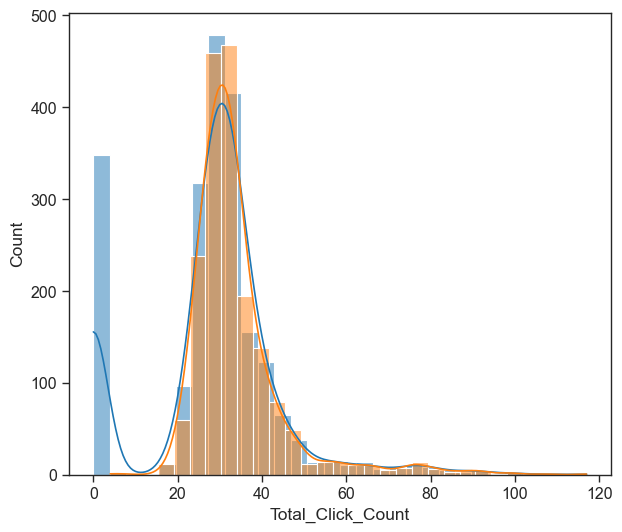

In [97]:
# Drop respondents with zero total click count
def filter_zero_clicks(df,zero_click_threshold=0, plot = False):
    click_count_columns = [col for col in df.columns if "Click Count" in col]
    df = df.dropna(subset=click_count_columns)
    df["Total_Click_Count"] = df[click_count_columns].apply(pd.to_numeric, errors='coerce').fillna(0).sum(axis=1)
    if plot:
        sns.histplot(df["Total_Click_Count"], bins=30, kde=True, label="Before Filtering")
    filtered_df = df[df["Total_Click_Count"] > zero_click_threshold].copy()
    if plot:
        sns.histplot(filtered_df["Total_Click_Count"], bins=30, kde=True, label="After Filtering")
    return filtered_df



zero_click_threshold = 0
df_after_zero_clicks = filter_zero_clicks(df, zero_click_threshold=zero_click_threshold, plot=True)

RESULTS_TRACKER.append({
    "step": "Zero Clicks",
    "threshold": f"{zero_click_threshold:.2f}",
    "removed": len(df) - len(df_after_zero_clicks),
    "remaining": len(df_after_zero_clicks),
    "percentage_removed": (len(df) - len(df_after_zero_clicks)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_zero_clicks)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_zero_clicks) / len(df_processed) * 100,
    "description": "Removed entries with zero total click counts across all pages (This is total. We can try by page)."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_zero_clicks.copy()

In [98]:


# filter out respondents with duplicate submit timing vectors or only first position above 0
def filter_submit_timing(df, submit_timing_vectors_threshold):
    if not submit_timing_vectors_threshold:
        return df
    submit_columns = [col for col in df.columns if "Page Submit" in col]
    data = df.copy()
    submit_data = df[submit_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    submit_data = submit_data.apply(np.ceil).astype(int)
    
    submit_data["Submit_Vector"] = submit_data.apply(lambda row: tuple(row), axis=1)

    duplicate_submit_vectors = submit_data["Submit_Vector"].duplicated(keep=False)
    

    # identify rows with only first position above 0
    only_first_position_above_0 = submit_data["Submit_Vector"].apply(lambda x: (x[0] > 0) and all(v == 0 for v in x[1:]))
    to_filter = duplicate_submit_vectors | only_first_position_above_0
    filtered_df = df[~to_filter].copy()


    # # or: data that match when rounded to nearest integer
    submit_data = filtered_df[submit_columns].apply(pd.to_numeric, errors='coerce').fillna(0).round().astype(int)
    submit_data["Submit_Vector"] = submit_data.apply(lambda row: tuple(row), axis=1)
    
    # remove all rows with duplicate vectors
    duplicate_vectors = submit_data["Submit_Vector"].duplicated(keep=False)
    filtered_df = filtered_df[~duplicate_vectors].copy()

    return filtered_df

submit_timing_vectors_threshold = True

df_after_submit_timing_vectors = filter_submit_timing(df, submit_timing_vectors_threshold)
RESULTS_TRACKER.append({
    "step": "Duplicate Submit Vectors",
    "threshold": "True",
    "removed": len(df) - len(df_after_submit_timing_vectors),
    "remaining": len(df_after_submit_timing_vectors),
    "percentage_removed": (len(df) - len(df_after_submit_timing_vectors)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_submit_timing_vectors)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_submit_timing_vectors) / len(df_processed) * 100,
    "description": "Removed entries with duplicate submit timing vectors or only first position above 0."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_submit_timing_vectors.copy()




,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...
4,Zero Clicks,0.00,568,1811,23.875578,84.933444,15.066556,Removed entries with zero total click counts a...
5,Duplicate Submit Vectors,True,46,1765,2.540033,85.316140,14.683860,Removed entries with duplicate submit timing v...


In [ ]:
# filter out above 95th percentile for each page and under 5th percentile for each page (or anything under min number of seconds)
def filter_extreme_submits(df, low_quantile, high_quantile, lower_min_threshold):
    submit_columns = [col for col in df.columns if "Page Submit" in col]
    submit_data = df[submit_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    filtered_dfs = []
    for col in submit_columns:
        page_data = submit_data[[col]].copy()
        lower_threshold = page_data[col].quantile(low_quantile)
        upper_threshold = page_data[col].quantile(high_quantile)
        # set a minimum threshold of # seconds
        if lower_threshold < lower_min_threshold:
            # if the page is not Q3, set to threshold
            if col != "Q3_Page Submit (Timing - Page Submit)":
                lower_threshold = lower_min_threshold
        filtered_page_data = page_data[(page_data[col] > lower_threshold) & (page_data[col] < upper_threshold)]
        filtered_dfs.append(filtered_page_data)
    
    # get the intersection of all filtered dataframes
    filtered_df = pd.concat(filtered_dfs, axis=1, join='inner').drop_duplicates()
    final_filtered_df = df.loc[filtered_df.index]
    return final_filtered_df

submit_timing_quantile_settings = {
    "low_quantile": 0.05,
    "high_quantile": 0.95,
    "lower_min_threshold": 10
}

df_after_extreme_submits = filter_extreme_submits(df, **submit_timing_quantile_settings)
RESULTS_TRACKER.append({
    "step": "Extreme Submits",
    "threshold": "5th, 95th Percentile",
    "removed": len(df) - len(df_after_extreme_submits),
    "remaining": len(df_after_extreme_submits),
    "percentage_removed": (len(df) - len(df_after_extreme_submits)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_extreme_submits)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_extreme_submits) / len(df_processed) * 100,
    "description": "Removed entries with extreme submit counts (below 5th percentile or above 95th percentile for each page, with a minimum threshold of 20 seconds)."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_extreme_submits.copy()

,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...
4,Zero Clicks,0.00,568,1811,23.875578,84.933444,15.066556,Removed entries with zero total click counts a...
5,Duplicate Submit Vectors,True,46,1765,2.540033,85.316140,14.683860,Removed entries with duplicate submit timing v...
6,Extreme Submits,"5th, 95th Percentile",1056,709,59.830028,94.101498,5.898502,Removed entries with extreme submit counts (be...


In [100]:
# filter out respondents with 5th percentile and 95th percentile of duration
def filter_duration(df, low_quantile=0.05, high_quantile=0.95):
    if "Duration (in seconds)" in df.columns:
        duration_data = df["Duration (in seconds)"].dropna()
        lower_bound = duration_data.quantile(low_quantile)
        upper_bound = duration_data.quantile(high_quantile)
        filtered_df = df[(df["Duration (in seconds)"] > lower_bound) & (df["Duration (in seconds)"] < upper_bound)].copy()
        return filtered_df
    else:
        return df

duration_quantile_settings = {
    "low_quantile": 0.05,
    "high_quantile": 0.95
}
df_after_duration = filter_duration(df, **duration_quantile_settings)
RESULTS_TRACKER.append({
    "step": "Duration",
    "threshold": "5th, 95th Percentile",
    "removed": len(df) - len(df_after_duration),
    "remaining": len(df_after_duration),
    "percentage_removed": (len(df) - len(df_after_duration)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_duration)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_duration) / len(df_processed) * 100,
    "description": "Removed entries with survey duration below 5th percentile or above 95th percentile."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_duration.copy()

,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...
4,Zero Clicks,0.00,568,1811,23.875578,84.933444,15.066556,Removed entries with zero total click counts a...
5,Duplicate Submit Vectors,True,46,1765,2.540033,85.316140,14.683860,Removed entries with duplicate submit timing v...
6,Extreme Submits,"5th, 95th Percentile",1056,709,59.830028,94.101498,5.898502,Removed entries with extreme submit counts (be...
7,Duration,"5th, 95th Percentile",72,637,10.155148,94.700499,5.299501,Removed entries with survey duration below 5th...


# 4. Device UA

In [101]:
import re
import pandas as pd


_res_pattern = re.compile(r"^\s*(\d+)\s*x\s*(\d+)\s*$", re.IGNORECASE)

def _parse_resolution(res_str):
    if pd.isna(res_str):
        return None, None
    m = _res_pattern.match(str(res_str))
    if not m:
        return None, None
    w, h = int(m.group(1)), int(m.group(2))
    return w, h

def is_invalid_resolution_row(row):

    """Return True if the row should be dropped based on resolution + device rules."""
    
    RES_COL = "Q2_Resolution (Click to write the question text - Resolution)"
    DEV_COL = "Q_DeviceType"
    
    
    w, h = _parse_resolution(row.get(RES_COL))
    # Malformed or zero dims -> invalid
    if not w or not h:
        return True

    device = str(row.get(DEV_COL, "")).strip().lower()
    # Desktop with phone-sized viewport -> invalid
    if device == "desktop":
        if (w < 600) or (h < 600) or (w < 800 and h < 900):
            return True
    return False


def filter_invalid_resolutions(df_, resolution_thresholds):
    if not resolution_thresholds:
        return df_
    df = df_.copy()
    df["Invalid_Resolution"] = df.apply(is_invalid_resolution_row, axis=1)
    return df.loc[~df["Invalid_Resolution"]].copy()




resolution_thresholds = True
df_after_invalid_resolutions = filter_invalid_resolutions(df, resolution_thresholds)
RESULTS_TRACKER.append({
    "step": "Invalid Resolutions",
    "threshold": "True",
    "removed": len(df) - len(df_after_invalid_resolutions),
    "remaining": len(df_after_invalid_resolutions),
    "percentage_removed": (len(df) - len(df_after_invalid_resolutions)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_invalid_resolutions)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_invalid_resolutions) / len(df_processed) * 100,
    "description": "Removed entries with invalid screen resolutions based on device type."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_invalid_resolutions.copy()


,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...
4,Zero Clicks,0.00,568,1811,23.875578,84.933444,15.066556,Removed entries with zero total click counts a...
5,Duplicate Submit Vectors,True,46,1765,2.540033,85.316140,14.683860,Removed entries with duplicate submit timing v...
6,Extreme Submits,"5th, 95th Percentile",1056,709,59.830028,94.101498,5.898502,Removed entries with extreme submit counts (be...
7,Duration,"5th, 95th Percentile",72,637,10.155148,94.700499,5.299501,Removed entries with survey duration below 5th...
8,Invalid Resolutions,True,3,634,0.470958,94.725458,5.274542,Removed entries with invalid screen resolution...


In [102]:
import re
import pandas as pd



def _parse_res(s):
    try:
        w,h = map(int, re.findall(r'\d+', str(s))[:2])
        return w,h
    except Exception:
        return None, None

def filter_impossible_combinations(df, impossible_combinations_enabled=True):
    """
    Drops rows with impossible/implausible UA+OS combos. These are specific to the dataset that was
    collected.
    """
    
    if not impossible_combinations_enabled:
        return df
    
    BROWSER_COL = "Q2_Browser (Click to write the question text - Browser)"
    OS_COL      = "Q2_Operating System (Click to write the question text - Operating System)"
    VER_COL     = "Q2_Version (Click to write the question text - Version)"
    RES_COL     = "Q2_Resolution (Click to write the question text - Resolution)"
    DEV_COL     = "Q_DeviceType"

    b  = df[BROWSER_COL].astype(str)
    os = df[OS_COL].astype(str)
    v  = df[VER_COL].astype(str)
    r  = df[RES_COL].astype(str)
    d  = df[DEV_COL].astype(str).str.lower()

    # --- Browser <-> OS contradictions
    rule_mobile_safari_not_ios = (b.eq("Mobile Safari") & ~os.eq("iOS"))
    rule_safari_not_apple      = (b.eq("Safari") & ~os.isin(["Mac OS","iOS"]))
    rule_webview_not_android   = (b.eq("Chrome WebView") & ~os.eq("Android"))
    rule_samsung_not_android   = (b.eq("Samsung Internet") & ~os.eq("Android"))
    rule_silk_not_android      = (b.eq("Silk") & ~os.eq("Android"))
    inapp = ["Facebook","Instagram","TikTok","Pinterest","Snapchat","LinkedIn","WeChat"]
    rule_inapp_not_mobile_os   = (b.isin(inapp) & ~os.isin(["iOS","Android"]))
    ios_brands = ["Chrome iOS","Firefox iOS","Edge iOS"]
    rule_ios_brand_not_ios     = (b.isin(ios_brands) & ~os.eq("iOS"))

    # --- DeviceType <-> OS contradiction
    os_mobile   = os.str.contains(r"Android|iOS|iPhone|iPad", case=False, na=False)
    os_desktop  = os.str.contains(r"Windows|Mac|macOS|Linux|ChromeOS", case=False, na=False)
    dev_mobile  = d.eq("mobile")
    dev_desktop = d.eq("desktop")
    rule_device_os_contra = (dev_desktop & os_mobile) | (dev_mobile & os_desktop)

    # --- resolution sanity
    w_h = r.apply(_parse_res)
    w = pd.Series([x[0] for x in w_h], index=df.index)
    h = pd.Series([x[1] for x in w_h], index=df.index)
    rule_bad_res = r.eq("0x0") | w.isna() | h.isna() | (w<=0) | (h<=0)

    # --- Brave version sanity
    brave = b.str.strip().str.lower().eq("brave")
    brave_valid = v.str.match(r"^\d+\.\d+\.\d+\.\d+$") | v.str.match(r"^1\.\d+\.\d+$")
    rule_brave_bad = brave & ~brave_valid

    # final mask
    drop_mask = (
        rule_mobile_safari_not_ios |
        rule_safari_not_apple |
        rule_webview_not_android |
        rule_samsung_not_android |
        rule_silk_not_android |
        rule_inapp_not_mobile_os |
        rule_ios_brand_not_ios |
        rule_device_os_contra |
        rule_bad_res |
        rule_brave_bad
    )

    # flagged = df[drop_mask].copy()
    filtered_df    = df[~drop_mask].copy()

    return filtered_df

impossible_combinations_enabled = True
df_after_impossible = filter_impossible_combinations(df, impossible_combinations_enabled)

RESULTS_TRACKER.append({
    "step": "Device Fingerprint",
    "threshold": "True",
    "removed": len(df) - len(df_after_impossible),
    "remaining": len(df_after_impossible),
    "percentage_removed": (len(df) - len(df_after_impossible)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_impossible)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_impossible) / len(df_processed) * 100,
    "description": "Removed entries with impossible browser and operating system combinations."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_impossible.copy()


,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...
4,Zero Clicks,0.00,568,1811,23.875578,84.933444,15.066556,Removed entries with zero total click counts a...
5,Duplicate Submit Vectors,True,46,1765,2.540033,85.316140,14.683860,Removed entries with duplicate submit timing v...
6,Extreme Submits,"5th, 95th Percentile",1056,709,59.830028,94.101498,5.898502,Removed entries with extreme submit counts (be...
7,Duration,"5th, 95th Percentile",72,637,10.155148,94.700499,5.299501,Removed entries with survey duration below 5th...
8,Invalid Resolutions,True,3,634,0.470958,94.725458,5.274542,Removed entries with invalid screen resolution...
9,Device Fingerprint,True,12,622,1.892744,94.825291,5.174709,Removed entries with impossible browser and op...


In [103]:
import re
import pandas as pd

# function to filter out incoherent UA/device/resolution combos
def filter_ua_incoherent(df, fingerprinting_enabled=True):
    """
    Drops rows with:
      - missing/malformed browser version
      - Brave versions that don't match expected patterns
      - device <-> OS contradictions (e.g., Desktop + iOS/Android)
      - clearly impossible/invalid viewport captures
      - mobile reporting desktop-like width, or desktop with ultra-tiny width

    Keeps everything else (including in-app browsers / Chrome on iOS, etc.).
    """
    if not fingerprinting_enabled:
        return df

    # Helpers
    def parse_res(s):
        try:
            w, h = map(int, re.findall(r'\d+', str(s))[:2])
            return w, h
        except Exception:
            return None, None

    # Basic fields
    browser = df.get('Q2_Browser (Click to write the question text - Browser)', pd.Series([None]*len(df)))
    version = df.get('Q2_Version (Click to write the question text - Version)', pd.Series([None]*len(df)))
    os_     = df.get('Q2_Operating System (Click to write the question text - Operating System)', pd.Series([None]*len(df)))
    res     = df.get('Q2_Resolution (Click to write the question text - Resolution)', pd.Series([None]*len(df)))
    dev     = df.get('Q_DeviceType', pd.Series([None]*len(df)))

    # Parsed helpers
    w_h = res.apply(parse_res)
    w = pd.Series([x[0] for x in w_h], index=df.index)
    h = pd.Series([x[1] for x in w_h], index=df.index)

    is_mobile_dev   = dev.astype(str).str.lower().eq('mobile')
    is_desktop_dev  = dev.astype(str).str.lower().eq('desktop')

    os_str = os_.astype(str)
    os_mobile  = os_str.str.contains(r'Android|iOS|iPhone|iPad', case=False, na=False)
    os_desktop = os_str.str.contains(r'Windows|Mac|macOS|Linux|ChromeOS', case=False, na=False)

    ver_str = version.astype(str)

    # Rules
    rule_version_missing = ver_str.isna() | ver_str.eq('') | ver_str.str.lower().eq('nan')

    # Brave should report either Chromium-style "xx.xx.xx.xx" or Brave-style "1.xx.xx" (three-part, starting with 1)
    brave = browser.astype(str).str.strip().str.lower().eq('brave')
    brave_valid = (
        ver_str.str.match(r'^\d+\.\d+\.\d+\.\d+$') |      # Chromium-like
        ver_str.str.match(r'^1\.\d+\.\d+$')               # Brave 1.xx.xx style
    )
    rule_brave_bad = brave & ~brave_valid

    # Device - OS contradiction
    rule_device_os_contra = (is_desktop_dev & os_mobile) | (is_mobile_dev & os_desktop)

    # Resolution sanity
    rule_res_invalid = res.astype(str).eq('0x0') | w.isna() | h.isna() | (w<=0) | (h<=0)

    # "Mobile - with desktop-like width", and "Desktop - with tiny width"
    rule_mobile_desktopish_width = is_mobile_dev & (w >= 1200)
    rule_desktop_tiny_width      = is_desktop_dev & (w > 0) & (w < 300)

    drop_mask = (
        rule_version_missing |
        rule_brave_bad |
        rule_device_os_contra |
        rule_res_invalid |
        rule_mobile_desktopish_width |
        rule_desktop_tiny_width
    )

    filtered_df = df[~drop_mask].copy()
    return filtered_df

# example usage
fingerprinting_enabled = True
df_after_ua_filter = filter_ua_incoherent(df, fingerprinting_enabled=fingerprinting_enabled)
RESULTS_TRACKER.append({
    "step": "Inconsistent UA/Device/Resolution Combos",
    "threshold": "True",
    "removed": len(df) - len(df_after_ua_filter),
    "remaining": len(df_after_ua_filter),
    "percentage_removed": (len(df) - len(df_after_ua_filter)) / len(df) * 100,
    "overall_percentage_removed": (len(df_processed) - len(df_after_ua_filter)) / len(df_processed) * 100,
    "percentage_remaining": len(df_after_ua_filter) / len(df_processed) * 100,
    "description": "Removed entries with Inconsistent user agent/device/resolution combinations."
})
display(pd.DataFrame(RESULTS_TRACKER))
df = df_after_ua_filter.copy()


,step,threshold,removed,remaining,percentage_removed,overall_percentage_removed,percentage_remaining,description
0,Recaptcha Score,0.6,6082,5938,50.599002,50.599002,49.400998,Removed entries with Recaptcha Score below 0.5.
1,Fraud Score,30,2658,3280,44.762546,72.712146,27.287854,Removed entries with Fraud Score above 50.
2,Ambiguous Text Present,True,42,3238,1.280488,73.061564,26.938436,Removed entries with ambiguous text present.
3,Duplicate Removal,1,859,2379,26.528721,26.528721,73.471279,Removed entries marked as duplicates and those...
4,Zero Clicks,0.00,568,1811,23.875578,84.933444,15.066556,Removed entries with zero total click counts a...
5,Duplicate Submit Vectors,True,46,1765,2.540033,85.316140,14.683860,Removed entries with duplicate submit timing v...
6,Extreme Submits,"5th, 95th Percentile",1056,709,59.830028,94.101498,5.898502,Removed entries with extreme submit counts (be...
7,Duration,"5th, 95th Percentile",72,637,10.155148,94.700499,5.299501,Removed entries with survey duration below 5th...
8,Invalid Resolutions,True,3,634,0.470958,94.725458,5.274542,Removed entries with invalid screen resolution...
9,Device Fingerprint,True,12,622,1.892744,94.825291,5.174709,Removed entries with impossible browser and op...


In [104]:
# save results tracker to csv
pd.DataFrame(RESULTS_TRACKER).to_csv("../../data/results_tracker.csv", index=False)
final_df = df.copy()
final_df.to_csv("../../data/processed/survey_data_final.csv", index=False)
final_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,LocationLatitude,...,Q31 - Topics (Q31 - Topics),Q_AmbiguousTextPresent,Q_AmbiguousTextQuestions,Q_StraightliningCount,Q_StraightliningPercentage,Q_UnansweredPercentage,Q_UnansweredQuestions,Q_DeviceType,Total_Click_Count,Invalid_Resolution
9,2025-05-30 18:13:08,2025-05-30 18:16:14,IP Address,65.34.130.31,100,185,True,2025-05-30 18:16:15,R_3oGAKFUG7pUmyyB,28.1951,...,Unknown,False,NaN,0,0,0.0,NaN,Mobile,34.0,False
18,2025-05-30 18:22:28,2025-05-30 18:25:30,IP Address,73.199.86.87,100,181,True,2025-05-30 18:25:30,R_2AQEbHtRcikjUZB,40.7980,...,Unknown,False,NaN,0,0,0.0,NaN,Mobile,33.0,False
37,2025-05-30 18:29:52,2025-05-30 18:34:57,IP Address,74.221.10.74,100,305,True,2025-05-30 18:34:57,R_3MtwBnBsI5dDu6q,36.3293,...,Unknown,False,NaN,0,0,0.0,NaN,Mobile,33.0,False
53,2025-05-30 18:39:41,2025-05-30 18:45:33,IP Address,136.35.44.14,100,351,True,2025-05-30 18:45:33,R_72j6q6U5Tnvd0Yx,39.1134,...,Unknown,False,NaN,0,0,0.0,NaN,Mobile,39.0,False
86,2025-05-30 18:54:00,2025-05-30 19:04:05,IP Address,99.93.63.171,100,605,True,2025-05-30 19:04:06,R_2tET7By2XVIuPMy,25.7703,...,Unknown,False,NaN,0,0,0.0,NaN,Mobile,26.0,False
